Using device: cpu


Epoch 1/3: 100%|█████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.16it/s]


Epoch 1/3
Train Loss: 0.2540 Acc: 0.9217
Val Loss: 0.0915 Acc: 0.9972


Epoch 2/3: 100%|█████████████████████████████████████████████████████████████████████████| 250/250 [00:07<00:00, 31.52it/s]


Epoch 2/3
Train Loss: 0.0785 Acc: 0.9962
Val Loss: 0.0552 Acc: 0.9975


Epoch 3/3: 100%|█████████████████████████████████████████████████████████████████████████| 250/250 [00:07<00:00, 31.84it/s]


Epoch 3/3
Train Loss: 0.0426 Acc: 0.9995
Val Loss: 0.0302 Acc: 1.0000


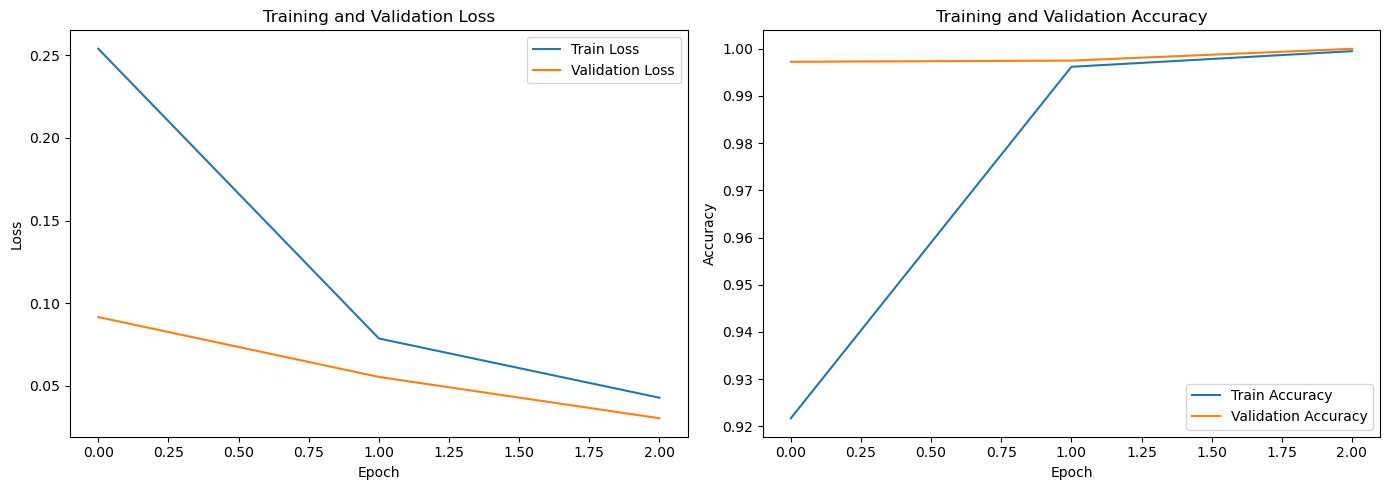

Validation Accuracy: 1.0000


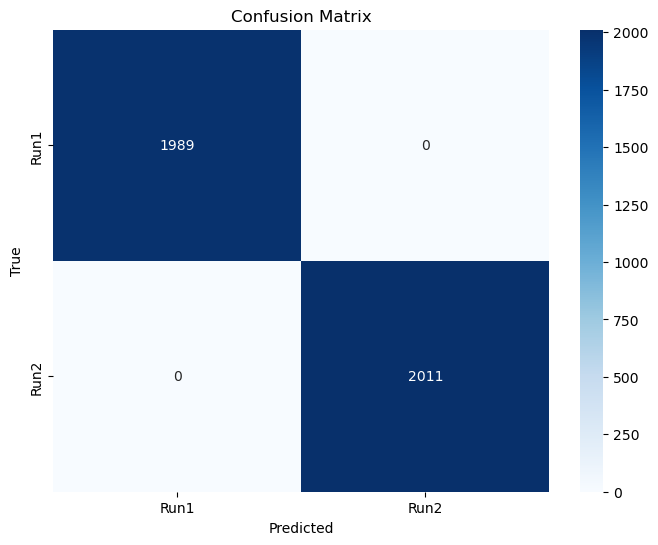

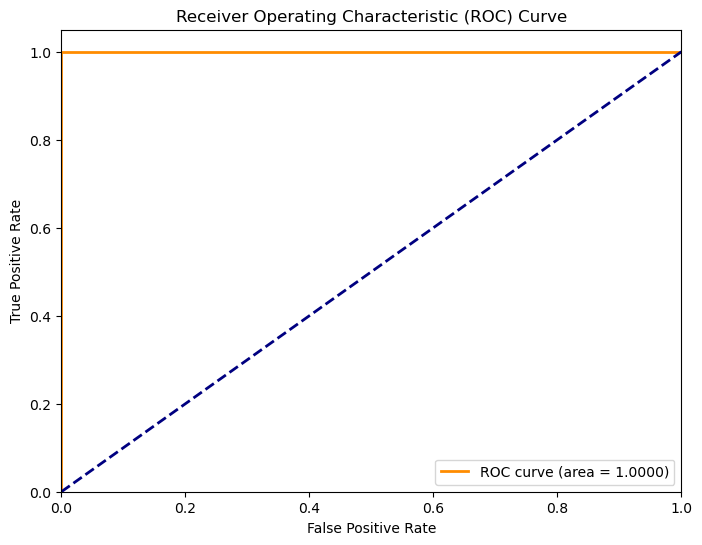

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

run1 = np.load("data/Run355456_Dataset_jqkne.npy")
run2 = np.load("data/Run357479_Dataset_iodic.npy")

def preprocess_data(run1, run2):
    run1_labels = np.zeros(run1.shape[0])
    run2_labels = np.ones(run2.shape[0])
    
    X = np.vstack([run1, run2])
    y = np.hstack([run1_labels, run2_labels])
    
    X_normalized = np.log1p(X)
    X_normalized = X_normalized.reshape(-1, 1, 64, 72)
    
    return X_normalized, y

X, y = preprocess_data(run1, run2)

class HCALDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

dataset = HCALDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class PatchEmbed(nn.Module):
    def __init__(self, img_size=(64, 72), patch_size=8, in_channels=1, embed_dim=256):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size[0] // patch_size) * (img_size[1] // patch_size)
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        
        return x, attn

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, drop=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(in_features=dim, hidden_features=int(dim * mlp_ratio), out_features=dim, drop=drop)
        
    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        x = x + y
        x = x + self.mlp(self.norm2(x))
        if return_attention:
            return x, attn
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=(64, 72), patch_size=8, in_channels=1, num_classes=2, embed_dim=256, 
                 depth=8, num_heads=8, mlp_ratio=4., qkv_bias=True, drop_rate=0.1, attn_drop_rate=0.):
        super().__init__()
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_channels=in_channels, embed_dim=embed_dim)
        num_patches = self.patch_embed.n_patches
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)
        
        self.blocks = nn.ModuleList([
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, 
                  drop=drop_rate, attn_drop=attn_drop_rate)
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
            
    def forward_features(self, x, return_attention=False):
        B = x.shape[0]
        x = self.patch_embed(x)
        
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        attention_maps = []
        for block in self.blocks:
            if return_attention:
                x, attn = block(x, return_attention=True)
                attention_maps.append(attn)
            else:
                x = block(x)
                
        x = self.norm(x)
        
        if return_attention:
            return x[:, 0], attention_maps
        return x[:, 0]
    
    def forward(self, x, return_attention=False):
        if return_attention:
            x, attention_maps = self.forward_features(x, return_attention=True)
            x = self.head(x)
            return x, attention_maps
        
        x = self.forward_features(x)
        x = self.head(x)
        return x

class MoEBlock(nn.Module):
    def __init__(self, dim, num_heads, num_experts=4, mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)
        
        self.experts = nn.ModuleList([
            MLP(in_features=dim, hidden_features=int(dim * mlp_ratio), out_features=dim, drop=drop)
            for _ in range(num_experts)
        ])
        
        self.router = nn.Linear(dim, num_experts)
        
    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        x = x + y
        
        z = self.norm2(x)
        router_logits = self.router(z)
        router_probs = nn.functional.softmax(router_logits, dim=-1)
        
        expert_outputs = 0
        for i, expert in enumerate(self.experts):
            expert_outputs += router_probs[:, :, i:i+1] * expert(z)
        
        x = x + expert_outputs
        
        if return_attention:
            return x, attn
        return x

class MoEVisionTransformer(nn.Module):
    def __init__(self, img_size=(64, 72), patch_size=8, in_channels=1, num_classes=2, embed_dim=256, 
                 depth=8, num_heads=8, num_experts=4, mlp_ratio=4., qkv_bias=True, drop_rate=0.1, attn_drop_rate=0.):
        super().__init__()
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_channels=in_channels, embed_dim=embed_dim)
        num_patches = self.patch_embed.n_patches
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)
        
        self.blocks = nn.ModuleList([
            MoEBlock(dim=embed_dim, num_heads=num_heads, num_experts=num_experts, mlp_ratio=mlp_ratio, 
                   qkv_bias=qkv_bias, drop=drop_rate, attn_drop=attn_drop_rate)
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
            
    def forward_features(self, x, return_attention=False):
        B = x.shape[0]
        x = self.patch_embed(x)
        
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        attention_maps = []
        for block in self.blocks:
            if return_attention:
                x, attn = block(x, return_attention=True)
                attention_maps.append(attn)
            else:
                x = block(x)
                
        x = self.norm(x)
        
        if return_attention:
            return x[:, 0], attention_maps
        return x[:, 0]
    
    def forward(self, x, return_attention=False):
        if return_attention:
            x, attention_maps = self.forward_features(x, return_attention=True)
            x = self.head(x)
            return x, attention_maps
        
        x = self.forward_features(x)
        x = self.head(x)
        return x

def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=20, device='cuda'):
    if torch.cuda.is_available() and device == 'cuda':
        device = torch.device('cuda')
        model = model.to(device)
    else:
        device = torch.device('cpu')
        model = model.to(device)
    
    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.item())
        
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)
        
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
        
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc.item())
        
        scheduler.step(val_epoch_loss)
        
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), 'best_vit_model.pth')
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
    
    return model, train_losses, val_losses, train_accs, val_accs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = VisionTransformer(
    img_size=(64, 72),
    patch_size=8*4,
    in_channels=1,
    num_classes=2,
    embed_dim=64,
    depth=4,
    num_heads=2,
    mlp_ratio=4.,
    qkv_bias=True,
    drop_rate=0.1,
    attn_drop_rate=0.0
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00003, weight_decay=0.05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

model, train_losses, val_losses, train_accs, val_accs = train_model(
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    criterion, 
    scheduler,
    num_epochs=3, 
    device=device
)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('images/training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

model.load_state_dict(torch.load('best_vit_model.pth'))
model.to(device)

preds, labels, probs = evaluate_model(model, val_loader, device)

accuracy = np.mean(preds == labels)
print(f"Validation Accuracy: {accuracy:.4f}")

conf_matrix = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Run1', 'Run2'], yticklabels=['Run1', 'Run2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('images/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('images/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

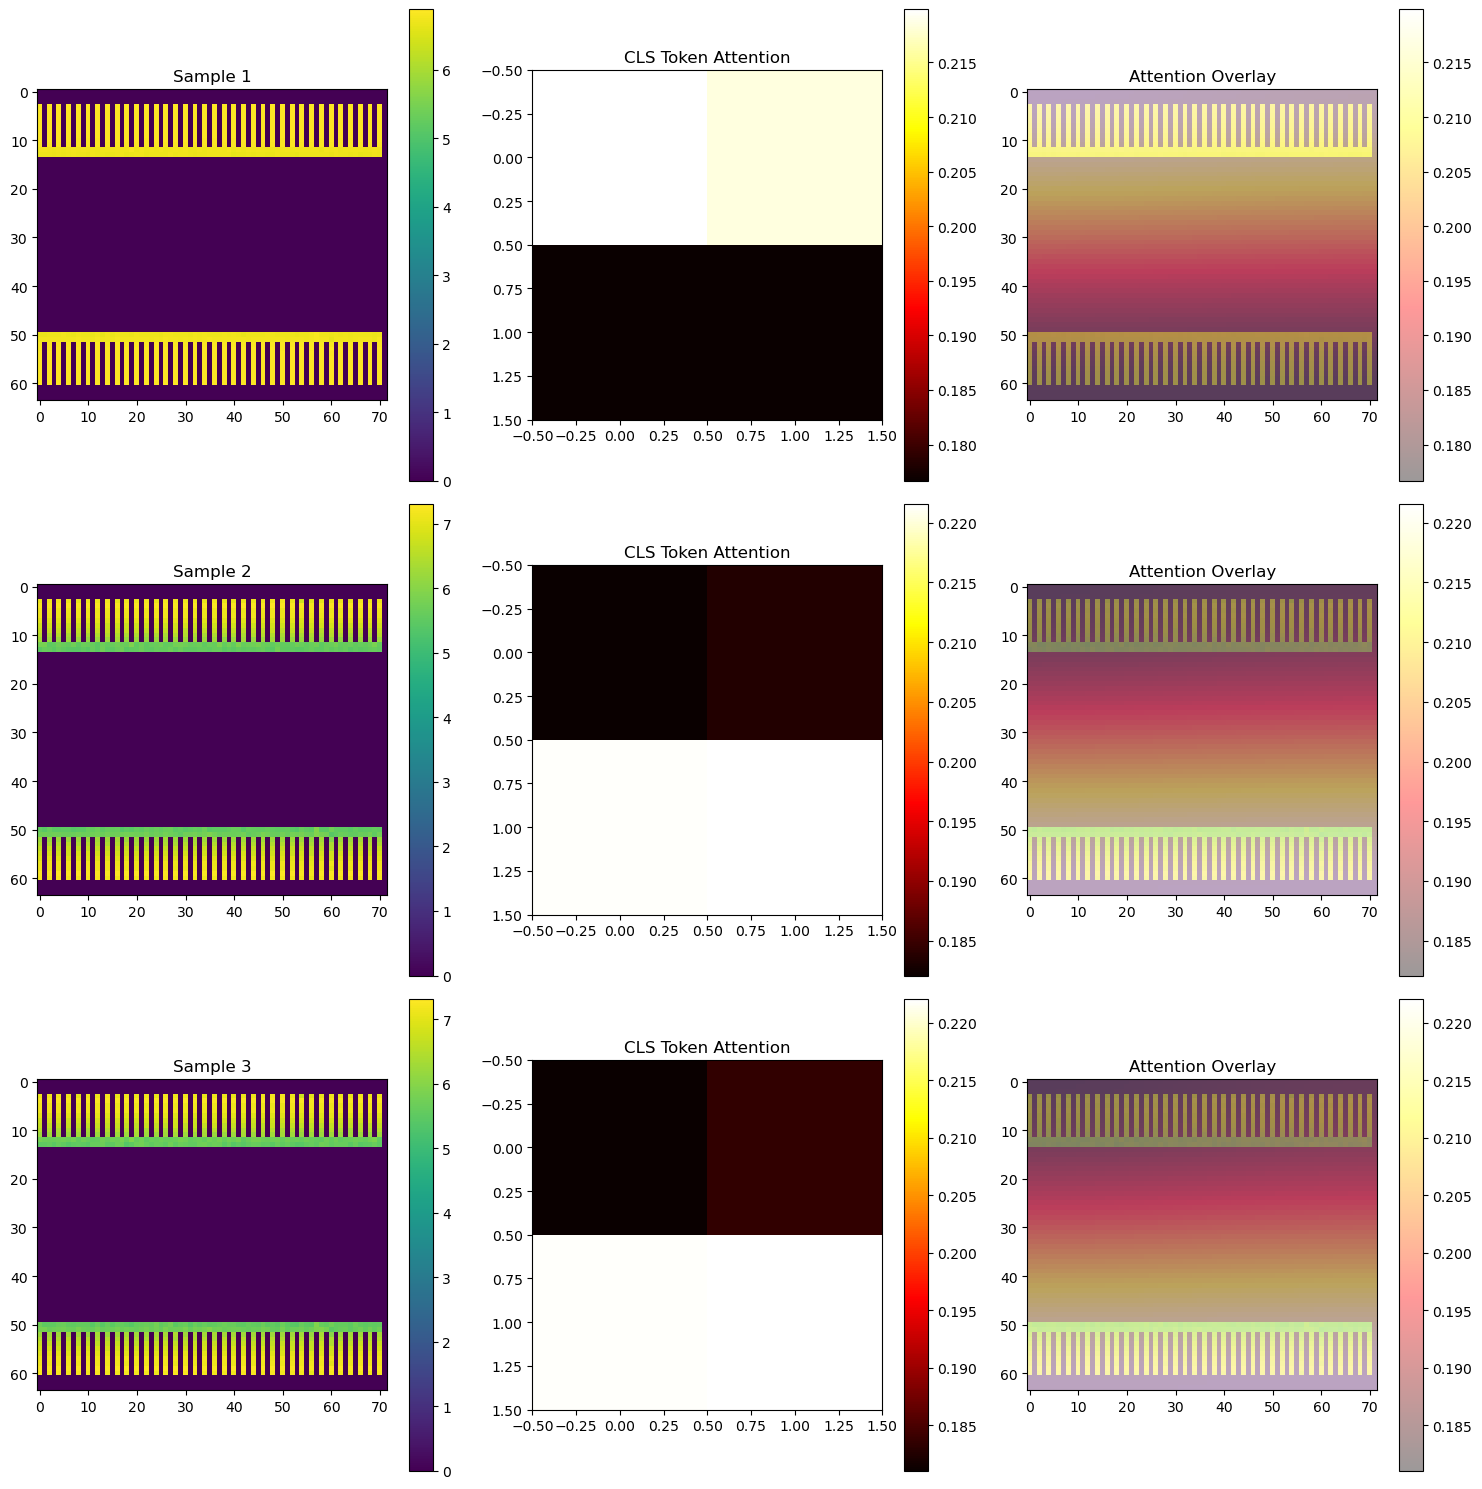

In [45]:
def visualize_attention(model, dataloader, device, num_samples=3):
    model.eval()
    images, attentions = [], []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            if len(images) >= num_samples:
                break
                
            inputs = inputs.to(device)
            _, attention_maps = model(inputs, return_attention=True)
            
            for i in range(min(num_samples - len(images), inputs.shape[0])):
                images.append(inputs[i].cpu().numpy())
                attentions.append(attention_maps[-1][i, 0].cpu().numpy())
    
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i in range(num_samples):
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(images[i][0], cmap='viridis')
        plt.title(f"Sample {i+1}")
        plt.colorbar()
        
        plt.subplot(num_samples, 3, i*3 + 2)
        attn = attentions[i][0, 1:]  # CLS token's attention to all patches
        
        # Get the actual size and use appropriate reshaping
        n_patches = attn.shape[0]
        grid_size = int(np.sqrt(n_patches))  # Assuming roughly square patches
        
        # If perfect square, reshape to square grid
        if grid_size * grid_size == n_patches:
            attn_reshaped = attn.reshape(grid_size, grid_size)
        else:
            # Otherwise, just use a 1D visualization
            attn_reshaped = attn.reshape(1, -1)
        
        plt.imshow(attn_reshaped, cmap='hot')
        plt.title("CLS Token Attention")
        plt.colorbar()
        
        plt.subplot(num_samples, 3, i*3 + 3)
        img = images[i][0]
        
        from scipy.ndimage import zoom
        zoom_h = img.shape[0] / attn_reshaped.shape[0]
        zoom_w = img.shape[1] / attn_reshaped.shape[1]
        attn_resized = zoom(attn_reshaped, (zoom_h, zoom_w))
        
        plt.imshow(img, alpha=0.6, cmap='viridis')
        plt.imshow(attn_resized, alpha=0.4, cmap='hot')
        plt.title("Attention Overlay")
        plt.colorbar()
    
    plt.tight_layout()
    plt.savefig('images/attention_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_attention(model, val_loader, device, num_samples=3)

## What We're Seeing:

### Left Images (Sample 1 & 2)
- These show the original **DigiOccupancy** data.
- Characteristic pattern: **two horizontal bands** of activity at **iEta positions 0-12 and 50-60**.
- Structured **striping patterns** indicate **particle hit counts** in different detector regions.

### Middle Images (CLS Token Attention)
- These visualize where the **classification (CLS) token** focuses its attention.
- The CLS token aggregates information for the **final classification decision**.
- Observations:
  - **Different focus patterns** between samples.
  - **Sample 1** focuses more on the **bottom half**.
  - **Sample 2** focuses more on the **top half**.

### Right Images (Attention Overlay)
- These overlay the **attention weights** on the original image.
- Show that the model primarily focuses on **active detector regions** (the **horizontal bands**).

## How the Attention Mechanism is Working:

### Selective Focus:
- The model has learned to **prioritize specific regions** that distinguish between **Run 355456 and Run 357479**.
- Instead of paying equal attention to the entire image, it **concentrates on discriminative features**.

Epoch 1/3: 100%|█████████████████████████████████████████████████████████████████████████| 250/250 [00:10<00:00, 23.44it/s]


Epoch 1/3
Train Loss: 0.6918 Acc: 0.5238
Val Loss: 0.6839 Acc: 0.6112


Epoch 2/3: 100%|█████████████████████████████████████████████████████████████████████████| 250/250 [00:09<00:00, 26.25it/s]


Epoch 2/3
Train Loss: 0.5674 Acc: 0.8061
Val Loss: 0.3512 Acc: 0.9972


Epoch 3/3: 100%|█████████████████████████████████████████████████████████████████████████| 250/250 [00:07<00:00, 32.11it/s]


Epoch 3/3
Train Loss: 0.3370 Acc: 0.9987
Val Loss: 0.3056 Acc: 0.9985
MoE-ViT Validation Accuracy: 0.9985


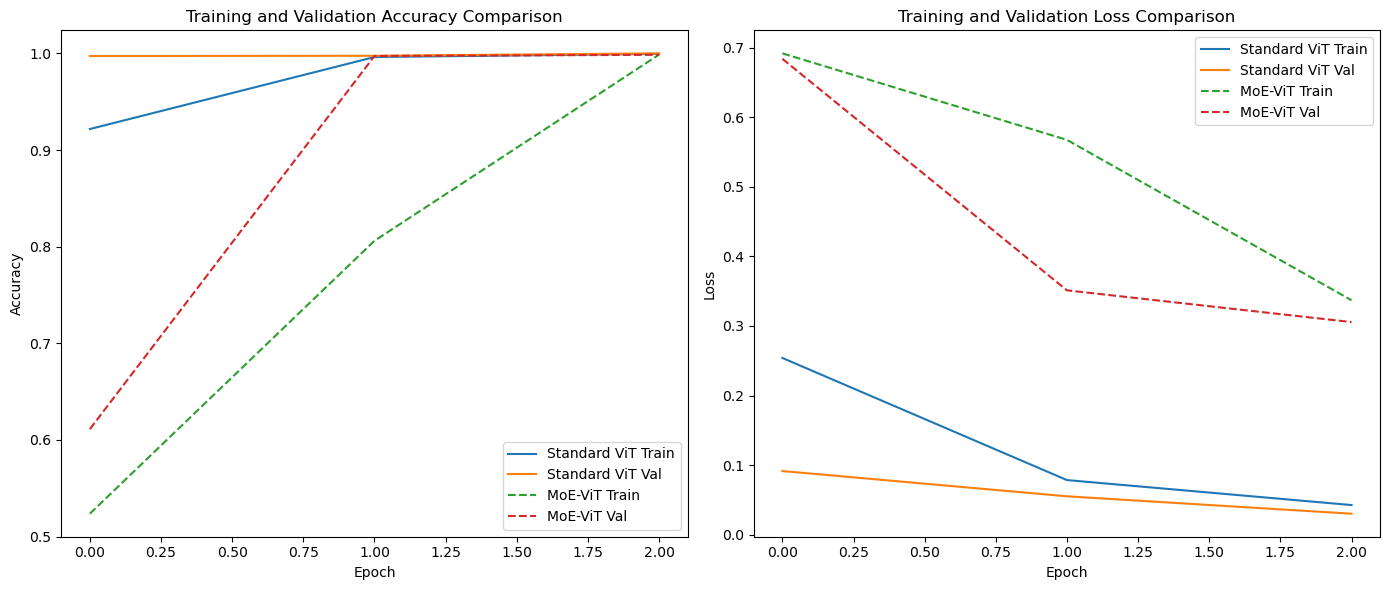

In [59]:
moe_model = MoEVisionTransformer(
    img_size=(64, 72),
    patch_size=8*4,
    in_channels=1,
    num_classes=2,
    embed_dim=256//8,
    depth=8//2,
    num_heads=8//4,
    num_experts=2,
    mlp_ratio=4.,
    qkv_bias=True,
    drop_rate=0.1,
    attn_drop_rate=0.0
)

moe_criterion = nn.CrossEntropyLoss()
moe_optimizer = optim.AdamW(moe_model.parameters(), lr=0.000005, weight_decay=0.05)
moe_scheduler = optim.lr_scheduler.ReduceLROnPlateau(moe_optimizer, 'min', patience=3, factor=0.5)

moe_model, moe_train_losses, moe_val_losses, moe_train_accs, moe_val_accs = train_model(
    moe_model, 
    train_loader, 
    val_loader, 
    moe_optimizer, 
    moe_criterion, 
    moe_scheduler,
    num_epochs=3, 
    device=device
)

moe_model.load_state_dict(torch.load('best_vit_moe_model.pth'))
moe_model.to(device)
moe_preds, moe_labels, moe_probs = evaluate_model(moe_model, val_loader, device)

moe_accuracy = np.mean(moe_preds == moe_labels)
print(f"MoE-ViT Validation Accuracy: {moe_accuracy:.4f}")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Standard ViT Train')
plt.plot(val_accs, label='Standard ViT Val')
plt.plot(moe_train_accs, label='MoE-ViT Train', linestyle='--')
plt.plot(moe_val_accs, label='MoE-ViT Val', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Standard ViT Train')
plt.plot(val_losses, label='Standard ViT Val')
plt.plot(moe_train_losses, label='MoE-ViT Train', linestyle='--')
plt.plot(moe_val_losses, label='MoE-ViT Val', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()

plt.tight_layout()
plt.savefig('images/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

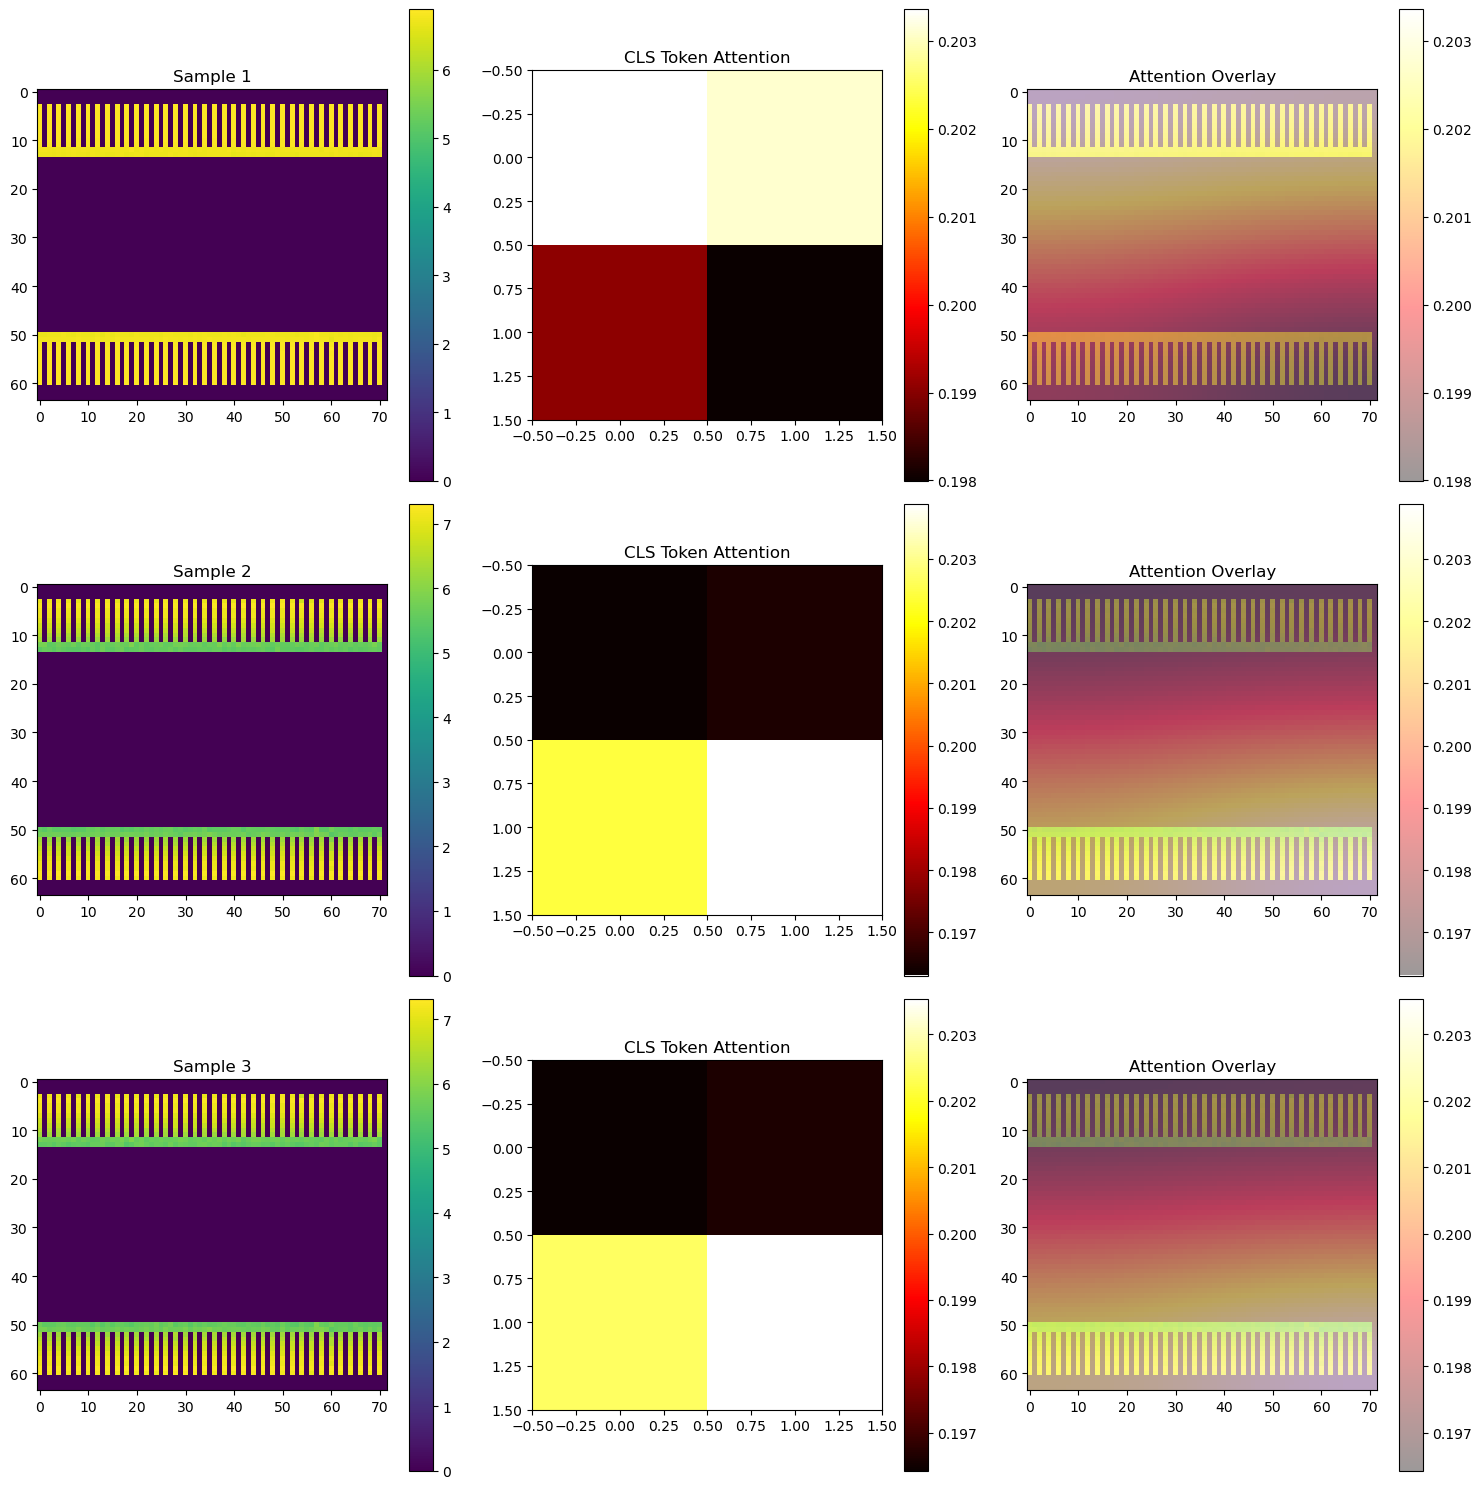

In [61]:
visualize_attention(moe_model, val_loader, device, num_samples=3)

## Key Differences from the Standard ViT:

### Structured Quadrant-Based Attention:
- The **MoE model** exhibits a **more structured** pattern with **distinct quadrants** in its attention maps.
- Suggests the model is **dividing the detector data** into specialized regions, with different **"experts"** focusing on different areas.

### Sample-Specific Routing:
- **Sample 1**: High attention (**red**) in the **upper right quadrant**.
- **Sample 2**: Completely different pattern, with attention concentrated in the **lower regions (yellow)**.
- Demonstrates that the **MoE architecture dynamically routes different samples** to different expert networks.

### Specialized Processing:
- Instead of broad attention across **entire active bands**, the MoE model is **more selective** about specific regions within those bands.

## What This Tells Us:

### Expert Specialization:
- Different **"experts"** in the MoE model specialize in different aspects of the detector data.
- Some experts might focus on **upper band patterns**, others on **lower band** features.

### Efficient Feature Learning:
- The model is **efficiently dividing** the classification task.
- Each expert **only** needs to become good at recognizing patterns **within its specialized region**.

### Dynamic Decision Making:
- The stark difference in **Sample 1 vs. Sample 2** attention patterns shows the **router network** is actively deciding which experts to engage.
- Decisions are based on the **specific characteristics** of each input.

### Physics-Aware Segmentation:
- The attention patterns suggest the model has **learned to segment the detector** in a **physically meaningful** way.
- This aligns with how **particle interactions manifest** in different regions.

# If we train the moe model more the experts kind of mergres and give same result as the standard one , so thats why we have to stop early in order to preserve the different experts optinion 

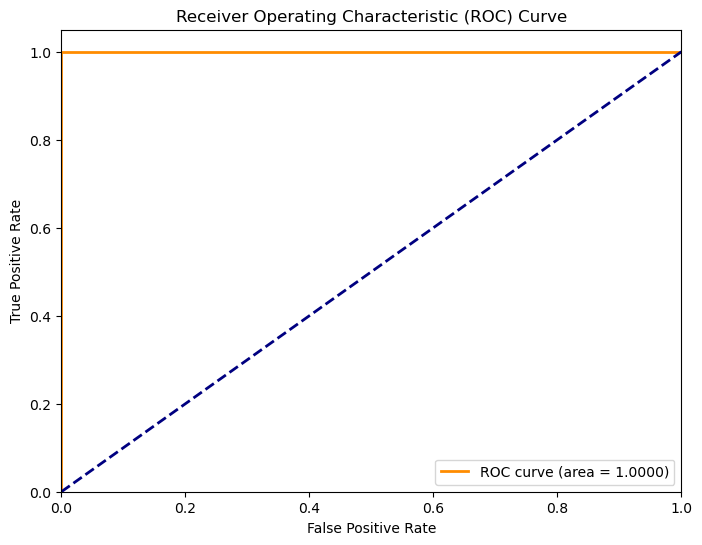

In [64]:
preds, labels, probs = evaluate_model(moe_model, val_loader, device)
fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('images/roc_curve_moe.png', dpi=300, bbox_inches='tight')
plt.show()